# Modules

In [1]:
import pandas as pd
import Hapi.rrm.hbv_bergestrom92 as HBVLumped
from Hapi.run import Run
from Hapi.catchment import Catchment
from Hapi.rrm.routing import Routing
import Hapi.statistics.performancecriteria as PC
from Hapi.statistics.sensitivityanalysis import SensitivityAnalysis as SA

#### Root path to the examples folder

In [6]:
Comp = "F:/01Algorithms/Hydrology/HAPI/Examples"

### Paths

In [7]:
Parameterpath = Comp + "/data/lumped/Coello_Lumped2021-03-08_muskingum.txt"
MeteoDataPath = Comp + "/data/lumped/meteo_data-MSWEP.csv"
Path = Comp + "/data/lumped/"

### Model data

In [10]:
### meteorological data
start = "2009-01-01"
end = "2011-12-31"
name = "Coello"
Coello = Catchment(name, start, end)
Coello.ReadLumpedInputs(MeteoDataPath)

### Basic_inputs
# catchment area
CatArea = 1530
# temporal resolution
# [Snow pack, Soil moisture, Upper zone, Lower Zone, Water content]
InitialCond = [0,10,10,10,0]

Coello.ReadLumpedModel(HBVLumped, CatArea, InitialCond)

### parameters
Snow = 0 # no snow subroutine
Coello.ReadParameters(Parameterpath, Snow)

parameters = pd.read_csv(Parameterpath, index_col = 0, header = None)
parameters.rename(columns={1:'value'}, inplace=True)

Lumped Model inputs are read successfully
Lumped model is read successfully
Parameters are read successfully


### Parameters Boundaries

In [12]:
UB = pd.read_csv(Path + "/UB-3.txt", index_col = 0, header = None)
parnames = UB.index
UB = UB[1].tolist()
LB = pd.read_csv(Path + "/LB-3.txt", index_col = 0, header = None)
LB = LB[1].tolist()
Coello.ReadParametersBounds(UB, LB, Snow)

Parameters bounds are read successfully


### Observed flow

In [13]:
Coello.ReadDischargeGauges(Path + "Qout_c.csv", fmt="%Y-%m-%d")
### Routing
Route=1
# RoutingFn=Routing.TriangularRouting2
RoutingFn = Routing.Muskingum

Gauges data are read successfully


### Run the model

In [15]:
Run.RunLumped(Coello, Route, RoutingFn)

Model Run has finished


### Performace

In [16]:
Metrics = dict()

Qobs = Coello.QGauges[Coello.QGauges.columns[0]]

Metrics['RMSE'] = PC.RMSE(Qobs, Coello.Qsim['q'])
Metrics['NSE'] = PC.NSE(Qobs, Coello.Qsim['q'])
Metrics['NSEhf'] = PC.NSEHF(Qobs, Coello.Qsim['q'])
Metrics['KGE'] = PC.KGE(Qobs, Coello.Qsim['q'])
Metrics['WB'] = PC.WB(Qobs, Coello.Qsim['q'])

print("RMSE= " + str(round(Metrics['RMSE'],2)))
print("NSE= " + str(round(Metrics['NSE'],2)))
print("NSEhf= " + str(round(Metrics['NSEhf'],2)))
print("KGE= " + str(round(Metrics['KGE'],2)))
print("WB= " + str(round(Metrics['WB'],2)))

RMSE= 26.03
NSE= 0.01
NSEhf= 0.17
KGE= 0.54
WB= 96.55


First the SensitivityAnalysis method takes 4 arguments :
    1-parameters:previous obtained parameters
    2-LB: upper bound
    3-UB: lower bound
    4-wrapper: defined function contains the function you want to run with different
        parameters and the metric function you want to assess the first function
        based on it.

- Wrapper function definition
    define the function to the OAT sesitivity wrapper and put the parameters argument
    at the first position, and then list all the other arguments required for your function

    the following defined function contains two inner function that calculates discharge
    for lumped HBV model and calculates the RMSE of the calculated discharge.

    the first function "RUN.RunLumped" takes some arguments we need to pass it through
    the SensitivityAnalysis method [ConceptualModel,data,p2,init_st,snow,Routing, RoutingFn]
    with the same order in the defined function "wrapper"

    the second function is RMSE takes the calculated discharge from the first function
    and measured discharge array

    to define the argument of the "wrapper" function
    1- the random parameters valiable i=of the first function should be the first argument
        "wrapper(Randpar)"
    2- the first function arguments with the same order (except that the parameter
            argument is taken out and placed at the first potition step-1)
    3- list the argument of the second function with the same order that the second
    function takes them

SensitivityAnalysis method returns a dictionary with the name of the parameters
as keys,
Each parameter has a disctionary with two keys 0: list of parameters woth relative values
1: list of parameter values


In [18]:
# For Type 1
def WrapperType1(Randpar,Route, RoutingFn, Qobs):
    Coello.Parameters = Randpar

    Run.RunLumped(Coello, Route, RoutingFn)
    rmse = PC.RMSE(Qobs, Coello.Qsim['q'])
    return rmse

# For Type 2
def WrapperType2(Randpar,Route, RoutingFn, Qobs):
    Coello.Parameters = Randpar

    Run.RunLumped(Coello, Route, RoutingFn)
    rmse = PC.RMSE(Qobs, Coello.Qsim['q'])
    return rmse, Coello.Qsim['q']

In [22]:
Type = 2
if Type ==1:
    fn = WrapperType1
elif Type == 2:
    fn = WrapperType2

Positions = [10]

In [20]:
Sen = SA(parameters, Coello.LB, Coello.UB, fn, Positions, 5, Type=Type)
Sen.OAT(Route, RoutingFn, Qobs)

Model Run has finished
10-k -0
26.026
Model Run has finished
10-k -1
26.011
Model Run has finished
10-k -2
25.997
Model Run has finished
10-k -3
25.983
Model Run has finished
10-k -4
25.97
Model Run has finished
10-k -5
25.957


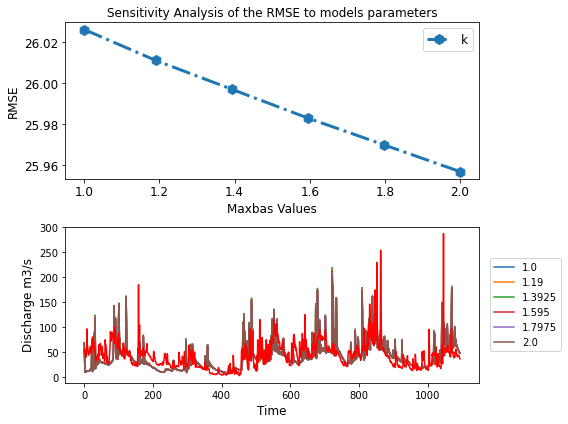

In [21]:
From = ''
To = ''
if Type ==1:
    fig, ax1 = Sen.Sobol(RealValues=False, Title="Sensitivity Analysis of the RMSE to models parameters",
              xlabel = "Maxbas Values", ylabel="RMSE", From=From, To=To,xlabel2='Time',
              ylabel2='Discharge m3/s', spaces=[None,None,None,None,None,None])
elif Type ==2:
    fig, (ax1,ax2) = Sen.Sobol(RealValues=False, Title="Sensitivity Analysis of the RMSE to models parameters",
              xlabel = "Maxbas Values", ylabel="RMSE", From=From, To=To,xlabel2='Time',
              ylabel2='Discharge m3/s', spaces=[None,None,None,None,None,None])
    From = 0
    To = len(Qobs.values)
    ax2.plot(Qobs.values[From:To], label='Observed', color='red')